In [3]:
import os, cv2, random, torch, pandas as pd
from PIL import Image, ImageDraw, ImageFont
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [12]:
image_folder_path = '../data-collection/images'  
label_folder_path = '../data-collection/labels'  

In [13]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):  
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            images.append((filename, img))
    return images

images = load_images_from_folder(image_folder_path)

In [14]:
# Verify the loaded images
for name, img in images:
    print(f"Loaded image: {name} with size {img.size}")

Loaded image: 009cbc0a-09152008flight2tape3_431.png with size (720, 480)
Loaded image: 015e2a80-out_2_2_92.png with size (720, 480)
Loaded image: 01f48b27-out_2_1_511.png with size (720, 480)
Loaded image: 02509f21-out_2_2_913.png with size (720, 480)
Loaded image: 02a1d698-out_2_3_19.png with size (720, 480)
Loaded image: 069e4b52-out_2_3_126.png with size (720, 480)
Loaded image: 06b65cae-09152008flight2tape3_951.png with size (720, 480)
Loaded image: 06c8cae3-out_2_3_226.png with size (720, 480)
Loaded image: 0849dbc6-out_2_2_86.png with size (720, 480)
Loaded image: 096b623b-out_2_3_223.png with size (720, 480)
Loaded image: 0b521441-out_2_2_52.png with size (720, 480)
Loaded image: 0bde31bb-09152008flight2tape3_435.png with size (720, 480)
Loaded image: 0be4b816-out_2_1_215.png with size (720, 480)
Loaded image: 0da35ee5-out_2_3_130.png with size (720, 480)
Loaded image: 0f083450-out_2_1_223.png with size (720, 480)
Loaded image: 0fa9771c-out_2_1_102.png with size (720, 480)
Loade

In [15]:
# Load labels from text file
label_files = os.listdir(label_folder_path)
labels = []
for file in label_files:
    with open(f"./{label_folder_path}/{file}", "r") as f:
        for line in f.read().split("\n")[:-1]:
            item = [file.replace(".txt", ".png")]
            item.extend(line.split(" "))
            labels.append(item)
            

In [16]:
# Check if the labels list is populated correctly
if labels:
    print(f"First few label entries: {labels[:5]}")
else:
    print("No labels found.")


First few label entries: [['009cbc0a-09152008flight2tape3_431.png', '0', '0.5145805293853747', '0.49663526244952894', '0.09241812471960514', '0.08882907133243606'], ['009cbc0a-09152008flight2tape3_431.png', '0', '0.6096904441453567', '0.5928667563930012', '0.101390758187528', '0.07940780619111706'], ['009cbc0a-09152008flight2tape3_431.png', '0', '0.9187976671152984', '0.65814266487214', '0.09152086137281301', '0.08613728129205925'], ['009cbc0a-09152008flight2tape3_431.png', '0', '0.8618214445939885', '0.8613728129205921', '0.11754149842978918', '0.0699865410497982'], ['009cbc0a-09152008flight2tape3_431.png', '0', '0.8851502916105878', '0.9057873485868103', '0.09062359802602074', '0.05921938088829066']]


In [17]:
# Create the DataFrame
df = pd.DataFrame(labels, columns=["file", "class", "x_center", "y_center", "width", "height"])

In [18]:
df[['x_center', 'y_center', 'width', 'height']] = df[['x_center', 'y_center', 'width', 'height']].astype(float)

df

,file,class,x_center,y_center,width,height
0,009cbc0a-09152008flight2tape3_431.png,0,0.514581,0.496635,0.092418,0.088829
1,009cbc0a-09152008flight2tape3_431.png,0,0.609690,0.592867,0.101391,0.079408
2,009cbc0a-09152008flight2tape3_431.png,0,0.918798,0.658143,0.091521,0.086137
3,009cbc0a-09152008flight2tape3_431.png,0,0.861821,0.861373,0.117541,0.069987
4,009cbc0a-09152008flight2tape3_431.png,0,0.885150,0.905787,0.090624,0.059219
...,...,...,...,...,...,...
1171,fe8b5f42-out_2_3_326.png,0,0.444594,0.670256,0.060117,0.115747
1172,fe8b5f42-out_2_3_326.png,0,0.679677,0.800135,0.052939,0.106326
1173,fe8b5f42-out_2_3_326.png,0,0.918798,0.646703,0.052041,0.090175
1174,ffcfdbbf-out_2_3_118.png,0,0.476895,0.372813,0.076267,0.096904


In [19]:
df["class"].unique()

array(['0'], dtype=object)

In [20]:
# Draw bounding boxes with RGB colors
def draw_bounding_boxes(image, labels):
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # RGB colors: Red, Green, Blue
    vehicle_count = 0
    print(f"Drawing bounding boxes for image size: {img_width}x{img_height}")
    
    for _, row in labels.iterrows():
        x_center = float(row['x_center']) * img_width
        y_center = float(row['y_center']) * img_height
        width = float(row['width']) * img_width
        height = float(row['height']) * img_height
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + width / 2
        color = random.choice(colors)  # Choose a random color for each bounding box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
        vehicle_count += 1
        print(f"Drew bounding box: ({x1}, {y1}), ({x2}, {y2})")
    
    # Display the number of vehicles
    font = ImageFont.load_default()
    text = f"Vehicles: {vehicle_count}"
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    draw.rectangle([(0, 0), (text_width + 10, text_height + 10)], fill="black")
    draw.text((5, 5), text, fill="white", font=font)
    print(f"Total vehicle count: {vehicle_count}")
    
    return image, vehicle_count


In [21]:
def pick_random_image(folder):
    image_files = [file for file in os.listdir(folder) if file.endswith(('.jpg', '.png'))]
    random_image = random.choice(image_files)
    return random_image

# Pick a random image
random_image_file = pick_random_image(image_folder_path)
print(f"Randomly selected image: {random_image_file}")

Randomly selected image: 672c8b56-out_2_3_217.png


In [22]:
# Select an image to display
image_to_display = random_image_file
image_labels = df[df['file'] == image_to_display]
print(f"Labels for image {image_to_display}:")
print(image_labels)

image_path = os.path.join(image_folder_path, image_to_display)
image = Image.open(image_path)
image_with_boxes, vehicle_count = draw_bounding_boxes(image, image_labels)
print(f"Number of vehicles: {vehicle_count}")
image_with_boxes.show()


Labels for image 672c8b56-out_2_3_217.png:
                         file class  x_center  y_center     width    height
463  672c8b56-out_2_3_217.png     0  0.798564  0.185734  0.026918  0.021534
464  672c8b56-out_2_3_217.png     0  0.831314  0.143338  0.033199  0.025572
465  672c8b56-out_2_3_217.png     0  0.848811  0.181696  0.030507  0.026918
466  672c8b56-out_2_3_217.png     0  0.835801  0.222746  0.018843  0.033647
467  672c8b56-out_2_3_217.png     0  0.849260  0.220054  0.018843  0.028264
468  672c8b56-out_2_3_217.png     0  0.962315  0.233513  0.022432  0.028264
469  672c8b56-out_2_3_217.png     0  0.036788  0.691790  0.037685  0.048452
Drawing bounding boxes for image size: 720x480
Drew bounding box: (565.2759084791386, 83.98384925975773), (584.6567967698519, 98.84253028263798)
Drew bounding box: (586.5948855989232, 62.66487213997308), (610.4979811574697, 80.75370121130551)
Drew bounding box: (600.1615074024227, 80.75370121130551), (622.1265141318978, 98.19650067294752)
Drew bou

In [23]:
# Normalize the bounding box coordinates
df[['x_center', 'y_center', 'width', 'height']] = df[['x_center', 'y_center', 'width', 'height']].astype(float)

In [32]:
# Resize images to a consistent size and preprocess the labels
image_size = (320, 320)
preprocessed_images = []
preprocessed_labels = []

output_image_folder = '../data-collection/PreprocessedImages'
os.makedirs(output_image_folder, exist_ok=True)

In [33]:
for name, img in images:
    
    # Resize image
    img_resized = img.resize(image_size)
    img_array = np.array(img_resized)
    
    # Save the resized image
    img_resized.save(os.path.join(output_image_folder, name))
    
    # Get corresponding labels
    img_labels = df[df['file'] == name]
    
    for _, row in img_labels.iterrows():
        x_center = row['x_center'] * image_size[0]
        y_center = row['y_center'] * image_size[1]
        width = row['width'] * image_size[0]
        height = row['height'] * image_size[1]
        
        # Normalize bounding box coordinates relative to the resized image dimensions
        norm_x_center = x_center / image_size[0]
        norm_y_center = y_center / image_size[1]
        norm_width = width / image_size[0]
        norm_height = height / image_size[1]
        
        preprocessed_labels.append([name, row['class'], norm_x_center, norm_y_center, norm_width, norm_height])



In [34]:
# Convert labels to DataFrame
preprocessed_labels_df = pd.DataFrame(preprocessed_labels, columns=["file", "class", "x_center", "y_center", "width", "height"])

In [35]:
# Save the preprocessed labels to a CSV file
preprocessed_labels_df.to_csv('preprocessed_labels.csv', index=False)

In [36]:
# Display sample preprocessed image with bounding boxes

def draw_bounding_boxes(image, labels):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)  # Convert ndarray to PIL Image
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # RGB colors: Red, Green, Blue
    vehicle_count = 0
    print(f"Drawing bounding boxes for image size: {img_width}x{img_height}")
    
    for _, row in labels.iterrows():
        x_center = float(row['x_center']) * img_width
        y_center = float(row['y_center']) * img_height
        width = float(row['width']) * img_width
        height = float(row['height']) * img_height
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        color = random.choice(colors)  # Choose a random color for each bounding box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
        vehicle_count += 1
        print(f"Drew bounding box: ({x1}, {y1}), ({x2}, {y2})")
    
    # Display the number of vehicles
    font = ImageFont.load_default()
    text = f"Vehicles: {vehicle_count}"
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    draw.rectangle([(0, 0), (text_width + 10, text_height + 10)], fill="black")
    draw.text((5, 5), text, fill="white", font=font)
    print(f"Total vehicle count: {vehicle_count}")
    
    return image, vehicle_count


In [37]:
# Select an image to display
image_to_display = random_image_file
image_labels = df[df['file'] == image_to_display]
print(f"Labels for image {image_to_display}:")
print(image_labels)

image_path = os.path.join(image_folder_path, image_to_display)
image = Image.open(image_path)
image_with_boxes, vehicle_count = draw_bounding_boxes(image, image_labels)
print(f"Number of vehicles: {vehicle_count}")
image_with_boxes.show()


Labels for image 672c8b56-out_2_3_217.png:
                         file class  x_center  y_center     width    height
463  672c8b56-out_2_3_217.png     0  0.798564  0.185734  0.026918  0.021534
464  672c8b56-out_2_3_217.png     0  0.831314  0.143338  0.033199  0.025572
465  672c8b56-out_2_3_217.png     0  0.848811  0.181696  0.030507  0.026918
466  672c8b56-out_2_3_217.png     0  0.835801  0.222746  0.018843  0.033647
467  672c8b56-out_2_3_217.png     0  0.849260  0.220054  0.018843  0.028264
468  672c8b56-out_2_3_217.png     0  0.962315  0.233513  0.022432  0.028264
469  672c8b56-out_2_3_217.png     0  0.036788  0.691790  0.037685  0.048452
Drawing bounding boxes for image size: 720x480
Drew bounding box: (565.2759084791386, 83.98384925975773), (584.6567967698519, 94.32032301480484)
Drew bounding box: (586.5948855989232, 62.66487213997308), (610.4979811574697, 74.93943472409151)
Drew bounding box: (600.1615074024227, 80.75370121130551), (622.1265141318978, 93.6742934051144)
Drew boun

In [38]:
# Example of displaying a preprocessed image with bounding boxes
example_image_name = random_image_file
example_image_path = os.path.join(output_image_folder, example_image_name)
example_image_array = np.array(Image.open(example_image_path))
example_labels = preprocessed_labels_df[preprocessed_labels_df['file'] == example_image_name]
print(f"Preprocessed labels for image {example_image_name}:")
print(example_labels)

image_with_boxes, vehicle_count = draw_bounding_boxes(example_image_array, example_labels)
print(f"Number of vehicles in preprocessed image: {vehicle_count}")
image_with_boxes.show()

Preprocessed labels for image 672c8b56-out_2_3_217.png:
                         file class  x_center  y_center     width    height
463  672c8b56-out_2_3_217.png     0  0.798564  0.185734  0.026918  0.021534
464  672c8b56-out_2_3_217.png     0  0.831314  0.143338  0.033199  0.025572
465  672c8b56-out_2_3_217.png     0  0.848811  0.181696  0.030507  0.026918
466  672c8b56-out_2_3_217.png     0  0.835801  0.222746  0.018843  0.033647
467  672c8b56-out_2_3_217.png     0  0.849260  0.220054  0.018843  0.028264
468  672c8b56-out_2_3_217.png     0  0.962315  0.233513  0.022432  0.028264
469  672c8b56-out_2_3_217.png     0  0.036788  0.691790  0.037685  0.048452
Drawing bounding boxes for image size: 320x320
Drew bounding box: (251.23373710183938, 55.989232839838486), (259.8474652310453, 62.880215343203226)
Drew bounding box: (260.7088380439659, 41.77658142664872), (271.33243606998656, 49.959623149394346)
Drew bounding box: (266.7384477344101, 53.83580080753701), (276.5006729475101, 62.449528

In [41]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torchvision.transforms as T

class VehicleDataset(Dataset):
    def __init__(self, image_folder, label_file, transform=None):
        self.image_folder = image_folder
        self.labels = pd.read_csv(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels['file'].unique())

    def __getitem__(self, idx):
        image_name = self.labels['file'].unique()[idx]
        image_path = os.path.join(self.image_folder, image_name)
        image = Image.open(image_path).convert("RGB")
        
        boxes = self.labels[self.labels['file'] == image_name]
        boxes = boxes[['x_center', 'y_center', 'width', 'height']].values
        boxes[:, 0] *= image.width
        boxes[:, 1] *= image.height
        boxes[:, 2] *= image.width
        boxes[:, 3] *= image.height
        
        if self.transform:
            image = self.transform(image)

        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.ones((len(boxes),), dtype=torch.int64)  # Assuming all objects are vehicles (label 1)

        return image, target

def collate_fn(batch):
    images, targets = list(zip(*batch))
    images = torch.stack(images, dim=0)
    
    targets = [{k: v for k, v in t.items()} for t in targets]

    return images, targets

transform = T.Compose([T.ToTensor()])

# Create dataset and dataloader
dataset = VehicleDataset(image_folder='../data-collection/PreprocessedImages', label_file='../dev/preprocessed_labels.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Example of loading a batch
images, targets = next(iter(dataloader))
print(images.shape)
print(targets)


torch.Size([2, 3, 320, 320])
[{'boxes': tensor([[130.2109,  58.1427,  39.3360,  30.1480],
        [129.9237, 271.7631,  33.5935,  29.2867],
        [168.5419, 258.6272,  26.4154,  26.2719],
        [195.9623,  95.1817,  28.4253,  45.6528],
        [267.8869, 295.2355,  21.2472,  27.1332]]), 'labels': tensor([1, 1, 1, 1, 1])}, {'boxes': tensor([[184.9080, 304.2799,  41.3459,  27.9946]]), 'labels': tensor([1])}]


In [42]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pre-trained Faster R-CNN model
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Number of classes (1 class for vehicle + 1 for background)
num_classes = 2
model = get_model(num_classes)


c:\Python3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\rubel/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:21<00:00, 7.67MB/s] 


In [43]:
# Load your dataset
label_file = './preprocessed_labels.csv'
labels_df = pd.read_csv(label_file)

# Print column names
print(labels_df.columns)

Index(['file', 'class', 'x_center', 'y_center', 'width', 'height'], dtype='object')


In [44]:
from torch.utils.data import DataLoader
import pandas as pd

# Function to check bounding box validity
def check_bounding_boxes(df):
    invalid_boxes = []
    for index, row in df.iterrows():
        x_center, y_center, width, height = row['x_center'], row['y_center'], row['width'], row['height']
        xmin, ymin = x_center - width / 2, y_center - height / 2
        xmax, ymax = x_center + width / 2, y_center + height / 2
        if (xmax <= xmin) or (ymax <= ymin):
            invalid_boxes.append((index, row))
    return invalid_boxes

# Check for invalid bounding boxes
invalid_boxes = check_bounding_boxes(labels_df)

# Print invalid bounding boxes
if invalid_boxes:
    print("Found invalid bounding boxes:")
    for idx, box in invalid_boxes:
        print(f"Index: {idx}, Box: {box}")
else:
    print("No invalid bounding boxes found.")


No invalid bounding boxes found.


In [46]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Define the dataset and dataloader
transform = T.Compose([T.ToTensor()])
dataset = VehicleDataset(image_folder='../data-collection/PreprocessedImages', label_file='../dev/preprocessed_labels.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Move the model to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Function to validate bounding boxes before training
def validate_bounding_boxes(targets):
    for target in targets:
        boxes = target['boxes']
        if not ((boxes[:, 2] > boxes[:, 0]).all() and (boxes[:, 3] > boxes[:, 1]).all()):
            return False, boxes
    return True, None

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    i = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Validate bounding boxes
        valid, invalid_boxes = validate_bounding_boxes(targets)
        if not valid:
            print(f"Invalid bounding boxes found: {invalid_boxes}")
            continue

        # Forward pass
        try:
            loss_dict = model(images, targets)
        except Exception as e:
            print(f"Error during forward pass: {e}")
            print(f"Images: {images}")
            print(f"Targets: {targets}")
            continue

        # Compute the total loss
        losses = sum(loss for loss in loss_dict.values())

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        losses.backward()

        # Update the parameters
        optimizer.step()
        
        running_loss += losses.item()
        
        # Print training information
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {losses.item():.4f}")
        i += 1

    print(f"Epoch [{epoch+1}/{num_epochs}] finished, Average Loss: {running_loss/len(dataloader):.4f}")

print("Training completed.")


Invalid bounding boxes found: tensor([[193.2346, 159.3540,  13.2077,  10.3365],
        [237.7389, 203.0686,  11.4850,  15.0740],
        [208.5958, 150.7402,  15.7918,   9.4751],
        [210.3185, 143.4186,  14.0691,   8.6137],
        [212.6155, 138.6810,  14.0691,  10.3365],
        [216.3481, 131.1440,  12.9206,  13.3513],
        [225.8232, 147.5101,   9.4751,   9.0444],
        [218.2144, 118.4388,  15.5047,   9.4751],
        [221.9471, 110.9017,  13.7820,   9.9058],
        [224.9619, 104.0108,  12.9206,   8.1830],
        [224.8183,  94.7510,  18.3760,  10.3365],
        [229.1252,  84.4145,  15.5047,  10.3365],
        [272.0502,  50.1750,   9.4751,  13.3513],
        [268.0305, 125.7604,  15.7918,  12.0592],
        [264.8721, 132.6514,  17.5146,  13.7820],
        [262.8623, 138.8964,  16.3661,  13.3513],
        [260.7088, 148.1561,  14.3562,  11.1978],
        [257.4069, 154.4011,  12.9206,   9.9058],
        [292.0054,  93.6743,  10.3365,   9.9058],
        [274.3472,  

Image shape: torch.Size([3, 320, 320])
Target boxes: [[ 85.85015678 259.27321434 120.30507088 298.46567726]]
Prediction boxes: [[ 45.11078644  97.01418304 178.08164215 351.82019806]
 [ 78.54488373  73.64401245 278.80939484 273.3848877 ]
 [ 24.55073547 125.80343628 153.32901001 432.90817261]
 [-73.82485962  57.75892639  98.32089233 352.75669861]
 [156.98654175  11.19010162 476.87612915  90.24667358]]
Prediction scores: [0.62295634 0.56779563 0.5411696  0.5394966  0.5169325 ]
Filtered Prediction boxes: [[  45.11078644   97.01418304  178.08164215  351.82019806]
 [  78.54488373   73.64401245  278.80939484  273.3848877 ]
 [  24.55073547  125.80343628  153.32901001  432.90817261]
 [ -73.82485962   57.75892639   98.32089233  352.75669861]
 [ 156.98654175   11.19010162  476.87612915   90.24667358]
 [  -3.22443342   18.32524681   12.85044336   77.81875801]
 [  79.04258728   51.14822388  262.85734558  180.47608948]
 [  -5.56989479   61.87365723   15.16590309  273.69726562]
 [  86.58087158   20.1

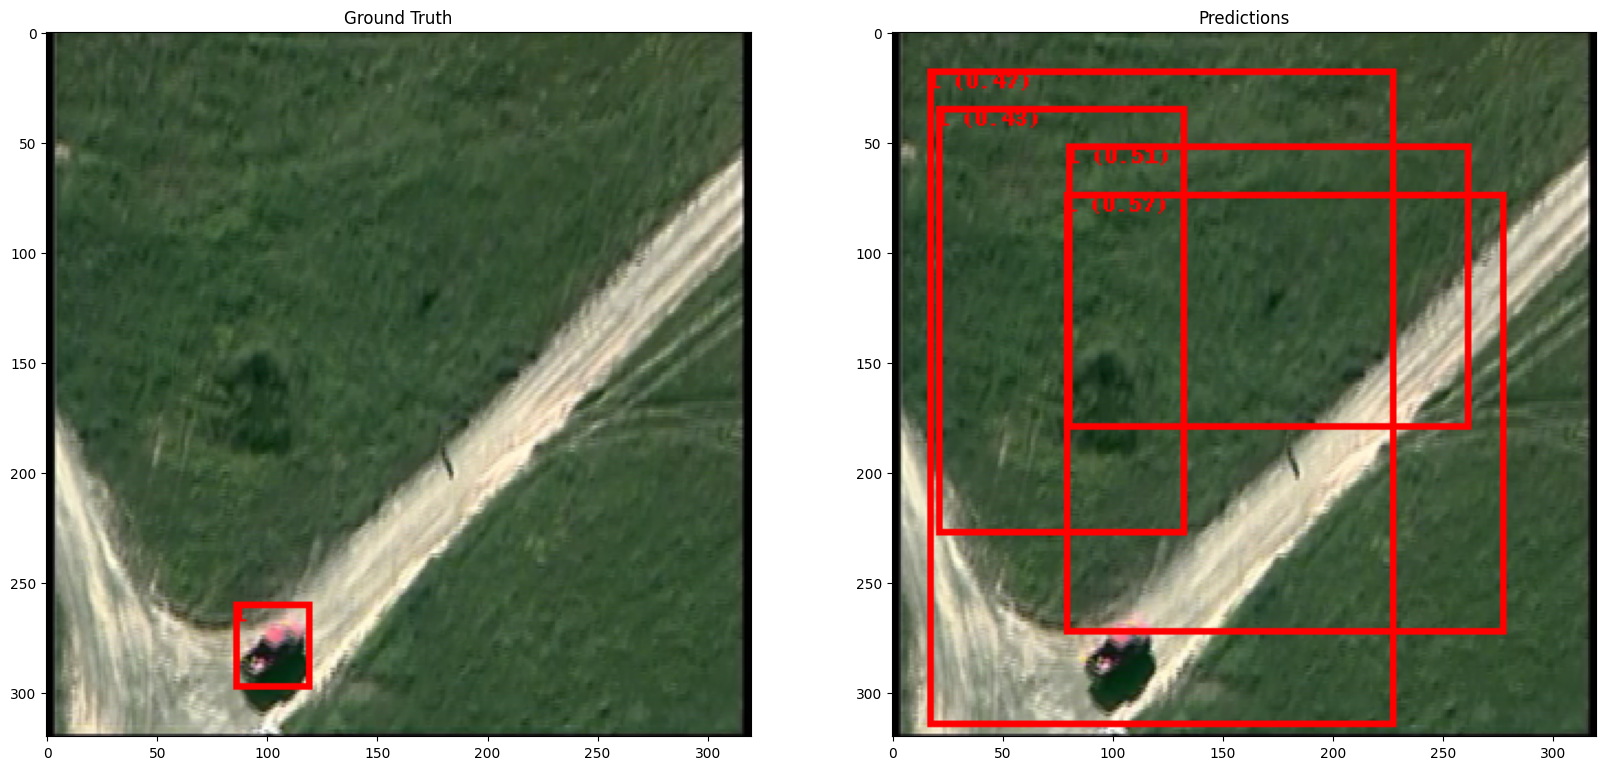

Image shape: torch.Size([3, 320, 320])
Target boxes: [[ 73.79094124 169.25976086 100.20637321 191.22476673]
 [133.22566605 255.8277235  150.74024582 284.25302601]
 [124.89905071 156.33916378 154.18572712 184.33377934]
 [138.68102646 153.32436562 168.82907486 180.02692223]
 [151.02735901 139.97308922 187.49214172 172.70525551]]
Prediction boxes: [[100.5750351    6.37965965 329.96729279  61.04194069]
 [105.57281494  15.32436371 410.70428467 116.30625153]
 [-20.6134491   74.70479584 119.89588928 268.56171417]
 [ 59.92275238   4.20756149 213.52225494  79.91257858]
 [114.82072449  18.45662117 361.73197937  79.48004723]]
Prediction scores: [0.62972564 0.6289387  0.6173481  0.5548606  0.54084986]
Filtered Prediction boxes: [[ 100.5750351     6.37965965  329.96729279   61.04194069]
 [ 105.57281494   15.32436371  410.70428467  116.30625153]
 [ -20.6134491    74.70479584  119.89588928  268.56171417]
 [  59.92275238    4.20756149  213.52225494   79.91257858]
 [ 114.82072449   18.45662117  361.731

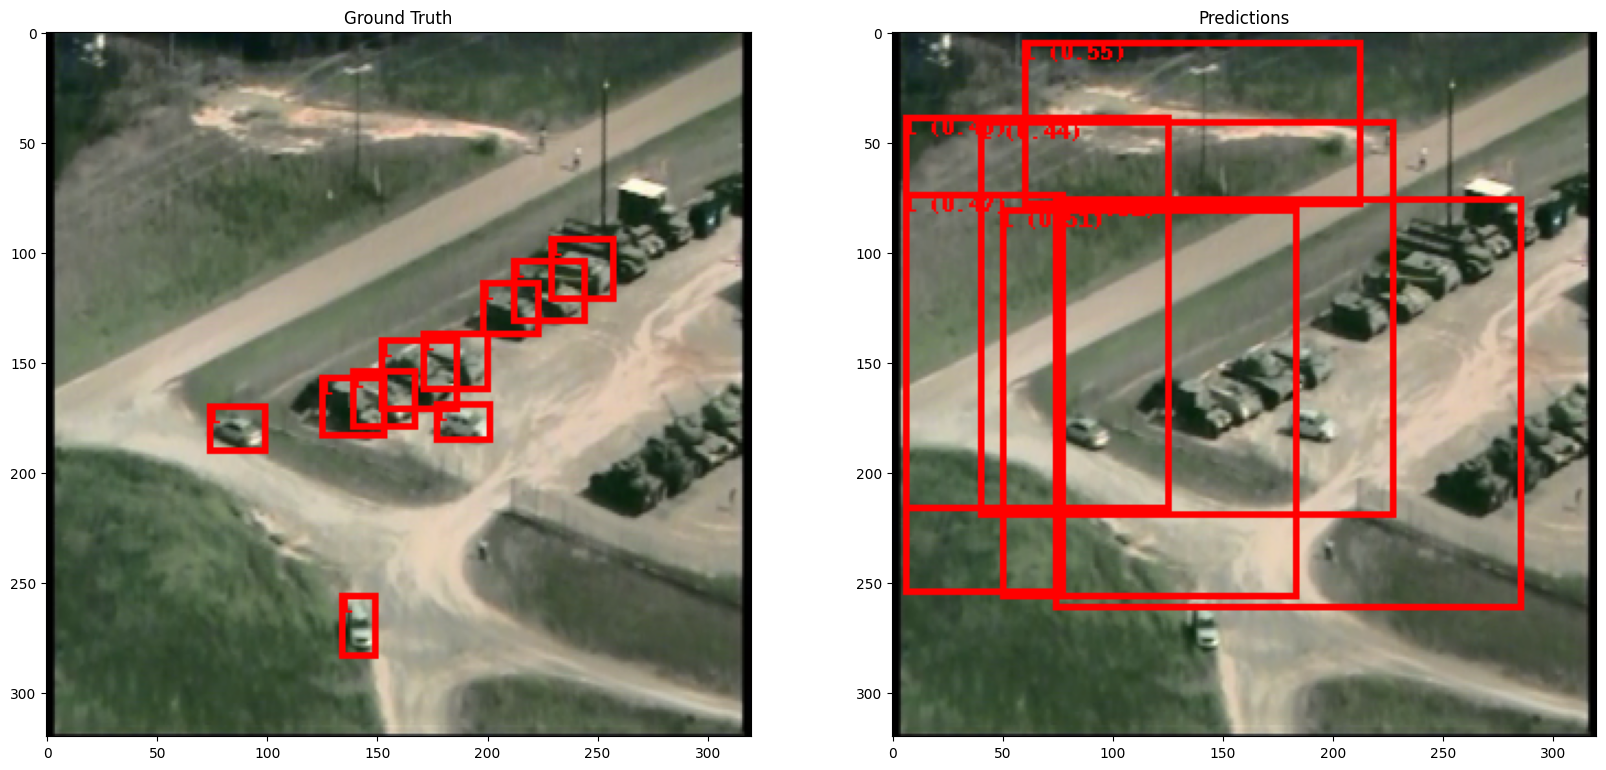

In [47]:
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from torchvision.ops import nms
from torchvision.transforms.functional import to_pil_image

# Function to convert from center to corner format
def convert_center_to_corner(boxes):
    new_boxes = []
    for box in boxes:
        x_center, y_center, width, height = box
        xmin = x_center - width / 2
        ymin = y_center - height / 2
        xmax = x_center + width / 2
        ymax = y_center + height / 2
        new_boxes.append([xmin, ymin, xmax, ymax])
    return np.array(new_boxes)

# Custom function to draw bounding boxes on an image
def draw_bounding_boxes(image, boxes, labels, scores=None, max_boxes=10):
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Convert CHW to HWC
        image = (image * 255).astype(np.uint8)  # Scale to 0-255
        image = Image.fromarray(image)
    elif isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    box_count = 0
    for i, (box, label) in enumerate(zip(boxes, labels)):
        xmin, ymin, xmax, ymax = box
        score = scores[i] if scores is not None else None
        # Ensure coordinates are valid
        if xmin >= xmax or ymin >= ymax or xmin < 0 or ymin < 0 or xmax > image.width or ymax > image.height:
            print(f"Invalid box: {xmin, ymin, xmax, ymax}")
            continue
        # Debug: print bounding box coordinates
        print(f"Drawing box: {xmin, ymin, xmax, ymax}, label: {label}, score: {score}")
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
        text = f"{label}" + (f" ({score:.2f})" if score is not None else "")
        draw.text((xmin, ymin), text, fill="red", font=font)
        box_count += 1
        if box_count >= max_boxes:
            break
    
    return image

def visualize_predictions(image, target, prediction, max_boxes=10, iou_threshold=0.5):
    # Convert target boxes and labels to numpy arrays for easy handling
    target_boxes = target['boxes'].cpu().numpy()
    target_labels = target['labels'].cpu().numpy()
    
    # Convert target boxes from center to corner format
    target_boxes = convert_center_to_corner(target_boxes)
    
    # Get predicted boxes, labels, and scores
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()
    pred_scores = prediction['scores'].cpu().numpy()
    
    # Convert predicted boxes from center to corner format
    pred_boxes = convert_center_to_corner(pred_boxes)

    # Apply Non-Max Suppression (NMS)
    pred_boxes_tensor = torch.tensor(pred_boxes, dtype=torch.float32)
    pred_scores_tensor = torch.tensor(pred_scores, dtype=torch.float32)
    keep = nms(pred_boxes_tensor, pred_scores_tensor, iou_threshold)
    pred_boxes = pred_boxes[keep.numpy()]
    pred_labels = pred_labels[keep.numpy()]
    pred_scores = pred_scores[keep.numpy()]

    # Debug: print shapes and some bounding boxes
    print(f"Image shape: {image.shape}")
    print(f"Target boxes: {target_boxes[:5]}")
    print(f"Prediction boxes: {pred_boxes[:5]}")
    print(f"Prediction scores: {pred_scores[:5]}")
    print(f"Filtered Prediction boxes: {pred_boxes}")
    print(f"Filtered Prediction scores: {pred_scores}")

    # Validate bounding box coordinates and filter out invalid ones
    valid_target_boxes = []
    valid_target_labels = []
    for box, label in zip(target_boxes, target_labels):
        x1, y1, x2, y2 = box
        if x1 < 0 or y1 < 0 or x2 > image.shape[2] or y2 > image.shape[1] or x1 >= x2 or y1 >= y2:
            print(f"Invalid ground truth box found: {box}")
            continue
        valid_target_boxes.append(box)
        valid_target_labels.append(label)

    image_np = image.cpu().permute(1, 2, 0).numpy()  # Convert to HWC format
    image_np = (image_np * 255).astype(np.uint8)  # Scale to 0-255
    
    # Draw ground truth boxes
    image_with_boxes = draw_bounding_boxes(image_np.copy(), valid_target_boxes, labels=[str(lbl) for lbl in valid_target_labels], max_boxes=max_boxes)  # Original bounding boxes
    
    # Draw predicted boxes
    image_with_pred_boxes = draw_bounding_boxes(image_np.copy(), pred_boxes, labels=[str(lbl) for lbl in pred_labels], scores=pred_scores, max_boxes=max_boxes)  # Predicted bounding boxes

    # Display images
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image_with_boxes)
    plt.title("Ground Truth")
    plt.subplot(1, 2, 2)
    plt.imshow(image_with_pred_boxes)
    plt.title("Predictions")
    plt.show()

# Load a batch from the validation set
val_images, val_targets = next(iter(dataloader))
val_images = list(image.to(device) for image in val_images)
val_targets = [{k: v.to(device) for k, v in t.items()} for t in val_targets]

# Set the model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    predictions = model(val_images)

# Visualize predictions
for img, tgt, pred in zip(val_images, val_targets, predictions):
    visualize_predictions(img, tgt, pred)


In [ ]:
last